In [47]:
#!pip install seaborn
!pip install openpyxl
!pip install pmdarima

You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\python\python.exe -m pip install --upgrade pip' command.


In [48]:
import pandas as pd
import numpy as np
import random as rd
import time
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from pmdarima.arima import auto_arima


In [49]:
#from google.colab import drive
#drive.mount('/content/drive')
arquivo = 'data/DS_Agua_2017_2022.csv'

In [50]:
dataset = pd.read_csv(arquivo, sep =';', encoding = 'latin1', decimal='.')

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45240 entries, 1 to 45240
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DT_MEDICAO_HORA         45240 non-null  object 
 1   PRECIPITACAO            45240 non-null  float64
 2   PRESSAO_ATMOSFERICA     45240 non-null  float64
 3   TEMPERATURA_DO_AR_C     45240 non-null  float64
 4   UMIDADE_RELATIVA_DO_AR  45240 non-null  float64
 5   VELOCIDADE_VENTO        45240 non-null  float64
 6   VL_MEDICAO              45240 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.8+ MB


In [52]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

DT_MEDICAO_HORA           0
PRECIPITACAO              0
PRESSAO_ATMOSFERICA       0
TEMPERATURA_DO_AR_C       0
UMIDADE_RELATIVA_DO_AR    0
VELOCIDADE_VENTO          0
VL_MEDICAO                0
dtype: int64

In [53]:
dataset.head(10)

,DT_MEDICAO_HORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA_DO_AR_C,UMIDADE_RELATIVA_DO_AR,VELOCIDADE_VENTO,VL_MEDICAO
1,2017-01-01 00:00:00,0.0,1009.5,25.9,75.0,1.3,5016.845991
2,2017-01-01 01:00:00,0.0,1009.6,25.7,76.0,0.9,4998.296902
3,2017-01-01 02:00:00,0.0,1009.2,25.6,76.0,1.1,5013.330096
4,2017-01-01 03:00:00,0.0,1008.4,25.9,77.0,1.7,4972.739746
5,2017-01-01 04:00:00,0.0,1008.1,23.7,85.0,1.7,4921.942265
6,2017-01-01 05:00:00,0.2,1007.5,23.7,87.0,0.4,4838.136258
7,2017-01-01 06:00:00,0.0,1007.3,24.2,88.0,0.5,4833.215005
8,2017-01-01 07:00:00,0.0,1007.3,24.2,87.0,0.7,4795.247653
9,2017-01-01 08:00:00,0.0,1007.7,24.7,85.0,1.0,4763.098501
10,2017-01-01 09:00:00,0.0,1008.5,25.1,83.0,1.2,4715.598748


In [54]:
#tratando o dataframe
df = pd.DataFrame()
df['DATA']=pd.to_datetime(dataset['DT_MEDICAO_HORA'])
df['VL_MEDICAO']=dataset['VL_MEDICAO']

#transformação da série => janela deslizande com 1 passo de tempo
n_time_steps=2
for n_step in range(1,n_time_steps+1,1):
   df['vl-'+str(n_step)]=dataset['VL_MEDICAO'].shift(n_step)  

df['tp-1']=dataset['TEMPERATURA_DO_AR_C']
df['pr-1']=dataset['PRESSAO_ATMOSFERICA']
df['vv-1']=dataset['VELOCIDADE_VENTO']
df['ur-1']=dataset['UMIDADE_RELATIVA_DO_AR']
df['ch-1']=dataset['PRECIPITACAO']

df.dropna(inplace=True)
df.head(5)

,DATA,VL_MEDICAO,vl-1,vl-2,tp-1,pr-1,vv-1,ur-1,ch-1
3,2017-01-01 02:00:00,5013.330096,4998.296902,5016.845991,25.6,1009.2,1.1,76.0,0.0
4,2017-01-01 03:00:00,4972.739746,5013.330096,4998.296902,25.9,1008.4,1.7,77.0,0.0
5,2017-01-01 04:00:00,4921.942265,4972.739746,5013.330096,23.7,1008.1,1.7,85.0,0.0
6,2017-01-01 05:00:00,4838.136258,4921.942265,4972.739746,23.7,1007.5,0.4,87.0,0.2
7,2017-01-01 06:00:00,4833.215005,4838.136258,4921.942265,24.2,1007.3,0.5,88.0,0.0


array([<AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>,
       <AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>,
       <AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>,
       <AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>],
      dtype=object)

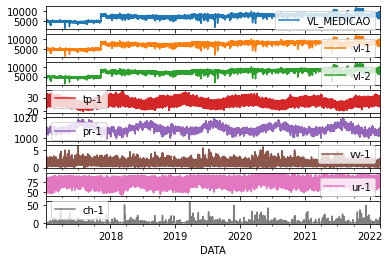

In [55]:
# indexing timestamp
ts_df=df.set_index('DATA')
ts_df.plot(subplots=True)

array([<AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>,
       <AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>,
       <AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>,
       <AxesSubplot:xlabel='DATA'>, <AxesSubplot:xlabel='DATA'>],
      dtype=object)

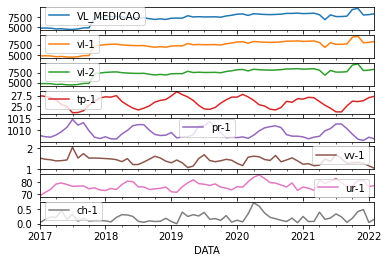

In [56]:
# graph for month time series
ts_df.resample('M').mean().plot(subplots=True)


In [57]:
model = auto_arima(ts_df['VL_MEDICAO'], X = ts_df.drop(columns=['VL_MEDICAO']),
                        m=24, seasonal=False, max_d = 2,
                      start_p=0, start_q=0, max_p=4, max_q=4, 
                      test='adf', stepwise=True, trace=True)

c:\Python\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=650648.128, Time=80.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=650356.849, Time=18.81 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=649087.388, Time=47.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=647844.863, Time=72.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=647809.535, Time=62.95 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=649674.057, Time=20.64 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=647951.820, Time=81.00 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=647750.029, Time=36.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=647870.987, Time=64.71 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=647736.311, Time=62.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=647743.828, Time=89.63 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=647729.056, Time=80.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=647715.822, Time=267.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=647674.914, Time=

In [ ]:
dataset.head(5)

,DT_MEDICAO_HORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA_DO_AR_C,UMIDADE_RELATIVA_DO_AR,VELOCIDADE_VENTO,VL_MEDICAO
1,2017-01-01 00:00:00,0.0,1009.5,25.9,75.0,1.3,5016.845991
2,2017-01-01 01:00:00,0.0,1009.6,25.7,76.0,0.9,4998.296902
3,2017-01-01 02:00:00,0.0,1009.2,25.6,76.0,1.1,5013.330096
4,2017-01-01 03:00:00,0.0,1008.4,25.9,77.0,1.7,4972.739746
5,2017-01-01 04:00:00,0.0,1008.1,23.7,85.0,1.7,4921.942265


In [ ]:
  #Split dataset in treinam /  75% treinam  25% test
  nlinhas = int(np.round(df.shape[0] *0.75)) # 
  
  max_size_train_split = int(np.round(nlinhas / 5)) 
  max_size__test_split = int(np.round((df.shape[0] - nlinhas) / 5))
  size_split = 5
  X_train = df.iloc[0:nlinhas,1:6 + n_time_steps]
  y_train = df.iloc[0:nlinhas,0].values

  X_test = df.iloc[nlinhas:dataset.shape[0],1: 6 + n_time_steps] 
  y_test = df.iloc[nlinhas:dataset.shape[0],0].values


In [ ]:
print(model.params)

In [ ]:
model.fit(np.array(X_train))


ARIMA(order=(4, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
predict=model.predict(n_periods=y_test.shape[0], X=X_test, alpha=0.01)

<AxesSubplot:>

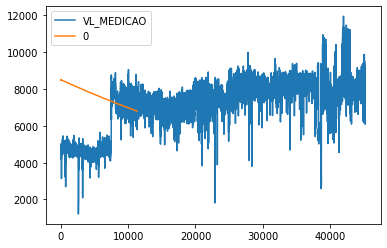

In [ ]:
df_predict = pd.DataFrame(predict[0])
pd.concat([df['VL_MEDICAO'],df_predict],axis=1).plot()

In [ ]:
  # Armazena a hora de início da execução do Treinamento
  Hora_Inicio = time.time()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# Validados cruzado para séries temporais
ts_cv = TimeSeriesSplit(
      n_splits=size_split, # Number of divisions
      max_train_size=max_size_train_split,    # maximum size of each set. of training
      gap=2, # number of samples to exclude between each training and testing set
      test_size=max_size__test_split, # maximum size of each set. of test.
)
param_grid = {
    'hidden_layer_sizes': [(6,12,1),(6,12,24,1),(6,18,1)], # camadas da MLP
    'max_iter': [50, 100, 150, 200], # máximo de iterações
    'activation': [ 'relu','identity'], #função de ativação
    'solver': ['adam'], #algorítmo para otimização do peso
    'alpha': [0.0001, 0.001, 0.05],  # força do alfa de regularização  
}

from sklearn.neural_network import MLPRegressor
modelo = MLPRegressor()

grid = GridSearchCV(modelo, param_grid, n_jobs= -1,scoring='neg_mean_absolute_percentage_error', cv=ts_cv, verbose=1)
grid.fit(np.array(X_train), np.array(y_train))

print(grid.best_params_) 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (6, 12, 1), 'max_iter': 100, 'solver': 'adam'}


In [ ]:
predict=grid.predict(np.array(X_test))
predict

# Armazena a hora fim da execução do Treinamento
Hora_Fim = time.time()

#Calcula o tempo de duração da execução do treinamento
Duracao = Hora_Fim - Hora_Inicio

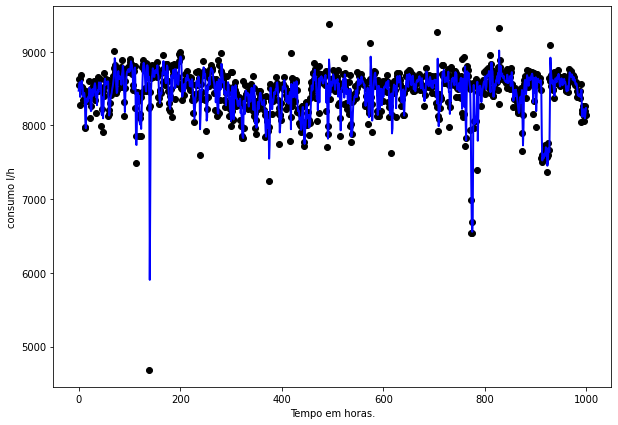

In [ ]:
#O gráfico abaixo mostra os valores reais em preto e os valores prditos em azul
npredicts=1000
pyplot.figure(figsize=(10,7)) 
pyplot.scatter(np.arange(0,y_test.shape[0],1)[0:npredicts],np.array(y_test)[0:npredicts], color = 'black')
pyplot.plot(np.arange(0,y_test.shape[0],1)[0:npredicts], np.array(predict)[0:npredicts], color = 'blue', linewidth=2)
pyplot.xlabel('Tempo em horas.')
pyplot.ylabel('consumo l/h')
pyplot.show()

In [ ]:
#Validação dos resultados

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

#Erro médio quadrático  (diferença quadrática média entre os valores estimados e o valor verdadeiro) - MSE
mean_squared_error(y_test,predict)



202040.2206683686

In [ ]:
#Raiz quadrada do Erro médio - RMSE
np.sqrt(mean_squared_error(y_test, predict))

449.488843764079

In [ ]:
#Distância absoluta média ou Erro médio absoluto - MAE

median_absolute_error(y_pred=predict, y_true = y_test)

117.62879468038591

In [ ]:
#Calcular o MAPE (Erro médio percentual absoluto)
MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100
MAPE

3.002822488083508